In [1]:
import pandas as pd
import numpy as np
import os

# Change to your 0S

os.chdir(r"C:\Users\Anna\Downloads")

# Change to your file names/paths

df_1 = pd.read_csv(r"movies_data\tmdb_5000_movies.csv")
df_2 = pd.read_csv(r"movies_data_2\TMDB_movie_dataset_v11.csv")

df_1 = df_1[['title', 'budget', 'original_language', 'release_date', 'revenue', 'runtime']]
df_2 = df_2[['title', 'genres', 'adult']]

movies_df = pd.merge(df_1, df_2, on="title", how="left")
movies_df = movies_df.drop_duplicates(subset=["title"]).reset_index(drop=True)

movies_df["is_adult"] = (movies_df["adult"].astype(str).str.strip().str.lower().isin(["true", "1", "yes"])).astype(int)

movies_df.drop(columns=["adult"], inplace=True)

movies_df["release_date"] = pd.to_datetime(movies_df["release_date"], errors="coerce")
movies_df["release_month"] = movies_df["release_date"].dt.month_name()

movies_df["is_success"] = (movies_df["revenue"] >= movies_df["budget"] * 2).astype(int)

print(movies_df)

                                         title     budget original_language  \
0                                       Avatar  237000000                en   
1     Pirates of the Caribbean: At World's End  300000000                en   
2                                      Spectre  245000000                en   
3                        The Dark Knight Rises  250000000                en   
4                                  John Carter  260000000                en   
...                                        ...        ...               ...   
4795                               El Mariachi     220000                es   
4796                                 Newlyweds       9000                en   
4797                 Signed, Sealed, Delivered          0                en   
4798                          Shanghai Calling          0                en   
4799                         My Date with Drew          0                en   

     release_date     revenue  runtime  \
0      20

In [2]:
from sklearn.preprocessing import MultiLabelBinarizer

def clean_genres(x):
    if isinstance(x, str):
        return [g.strip() for g in x.split(',') if g.strip()]
    else:
        return []

movies_df['genres'] = movies_df['genres'].apply(clean_genres)

movies_df['genres'].apply(type).value_counts()

genres
<class 'list'>    4800
Name: count, dtype: int64

In [3]:
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(movies_df['genres'])

genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)
movies_df = movies_df.join(genres_df)
movies_df = movies_df.drop(columns=['genres'])

In [4]:
movies_df.insert(loc=8, column='is_english?', value=(movies_df['original_language'] == 'en').astype(int))
movies_df.drop(columns=['original_language'], inplace=True)

In [5]:
month_df = pd.get_dummies(movies_df['release_month'], prefix='month')
month_df = month_df.astype(int)
movies_df = movies_df.join(month_df)
movies_df = movies_df.drop(columns=['release_date'])

In [6]:
movies_df['big_budget?'] = (movies_df['budget'] >= 100_000_000).astype(int)
movies_df.drop(columns=['budget'], inplace=True)

In [7]:
movies_df['long_runtime?'] = (movies_df['runtime'] >= 120).astype(int)
movies_df.drop(columns=['runtime'], inplace=True)

In [8]:
movies_df.drop(columns=['revenue'], inplace=True)

# Drop title column since we only need the movie index, not a string title value

movies_df.drop(columns=['title'], inplace=True)

In [9]:
columns_order = [
    'month_January', 'month_February', 'month_March', 'month_April', 'month_May', 'month_June', 'month_July', 'month_August',
    'month_September', 'month_October', 'month_November', 'month_December', 'big_budget?', 'long_runtime?', 'is_adult', 'is_english?',
    'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music',
    'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western', 'is_success'
]

movies_df = movies_df[columns_order]

# Drop all NaN values

movies_df = movies_df.dropna().reset_index(drop=True)

# Making all the values to integers to make it more uniform

for col in movies_df.columns:
    if movies_df[col].dropna().isin([0.0,1.0]).all():
        movies_df[col] = movies_df[col].astype(int)

movies_df.head()

,month_January,month_February,month_March,month_April,month_May,month_June,month_July,month_August,month_September,month_October,...,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,is_success
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [10]:
# Limits dataset to 1000 records per instructions and randomize using stratified sampling for more accuracy

from sklearn.model_selection import train_test_split

movies_df, _ = train_test_split(
    movies_df,
    train_size = 1000,
    stratify = movies_df['is_success'],
    random_state = 42
)

movies_df = movies_df.reset_index(drop=True)


In [11]:
#1st methodology: Logistic regression (Classification)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

X_predictor = movies_df[['month_January', 'month_February', 'month_March', 'month_April', 'month_May', 'month_June', 'month_July', 'month_August',
    'month_September', 'month_October', 'month_November', 'month_December', 'big_budget?', 'long_runtime?', 'is_adult', 'is_english?',
    'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music',
    'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']]

# All the months were perfectly colinear, resulting in the Singular Matrix error. December was dropped, making it the reference for all the other month coefficients
X_predictor = X_predictor.drop(columns=['month_December'])

#drops other perfectly correlated pairs, but keeps the first occurrence
corr = X_predictor.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] == 1)]
X_predictor = X_predictor.drop(columns=to_drop)
Y_dependent = movies_df['is_success']

#removed "constant" columns or columns where every value is identical, which can cause the singular matrix error
constant_cols = [c for c in X_predictor.columns if X_predictor[c].nunique() <= 1]
X_predictor = X_predictor.drop(columns=constant_cols)

X_predictor = sm.add_constant(X_predictor)
moviesuccess_logit = sm.Logit(Y_dependent,X_predictor).fit()
print(moviesuccess_logit.summary())


Optimization terminated successfully.
         Current function value: 0.642515
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             is_success   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      965
Method:                           MLE   Df Model:                           34
Date:                Tue, 09 Dec 2025   Pseudo R-squ.:                 0.04918
Time:                        13:43:44   Log-Likelihood:                -642.52
converged:                       True   LL-Null:                       -675.75
Covariance Type:            nonrobust   LLR p-value:                 0.0007205
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.8399      0.431      1.947      0.052      -0.006       1.686
month_January 

       Feature  Coefficient   P-value
33     Western    -1.298618  0.022358
24     History    -1.231904  0.001327
19       Crime    -0.504633  0.015974
5   month_June     0.877265  0.010983


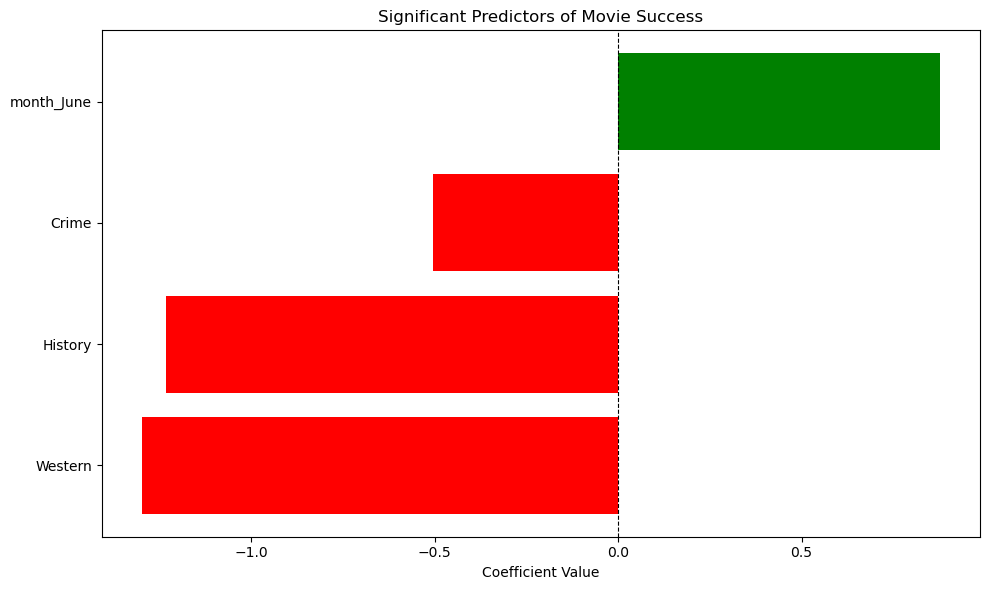

In [12]:
#Visualization of logistic regression

import matplotlib.pyplot as plt

coef_df = pd.DataFrame({
    'Feature': moviesuccess_logit.params.index[1:],
    'Coefficient': moviesuccess_logit.params.values[1:],
    'P-value': moviesuccess_logit.pvalues.values[1:]
})

coef_df = coef_df[coef_df['P-value'] < 0.05].sort_values('Coefficient')

plt.figure(figsize=(10,6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=['red' if x < 0 else 'green' for x in coef_df['Coefficient']])
plt.xlabel('Coefficient Value')
plt.title('Significant Predictors of Movie Success')
plt.axvline(x=0, color='black', linestyle= '--', linewidth=0.8)
plt.tight_layout()
print(coef_df)
plt.show()

In [13]:
#2nd methodology: Decision Tree (Classification)

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(X_predictor, Y_dependent)

y_pred_tree = tree.predict(X_predictor)
print(classification_report(Y_dependent, y_pred_tree))

              precision    recall  f1-score   support

           0       0.63      0.23      0.34       407
           1       0.63      0.91      0.75       593

    accuracy                           0.63      1000
   macro avg       0.63      0.57      0.54      1000
weighted avg       0.63      0.63      0.58      1000



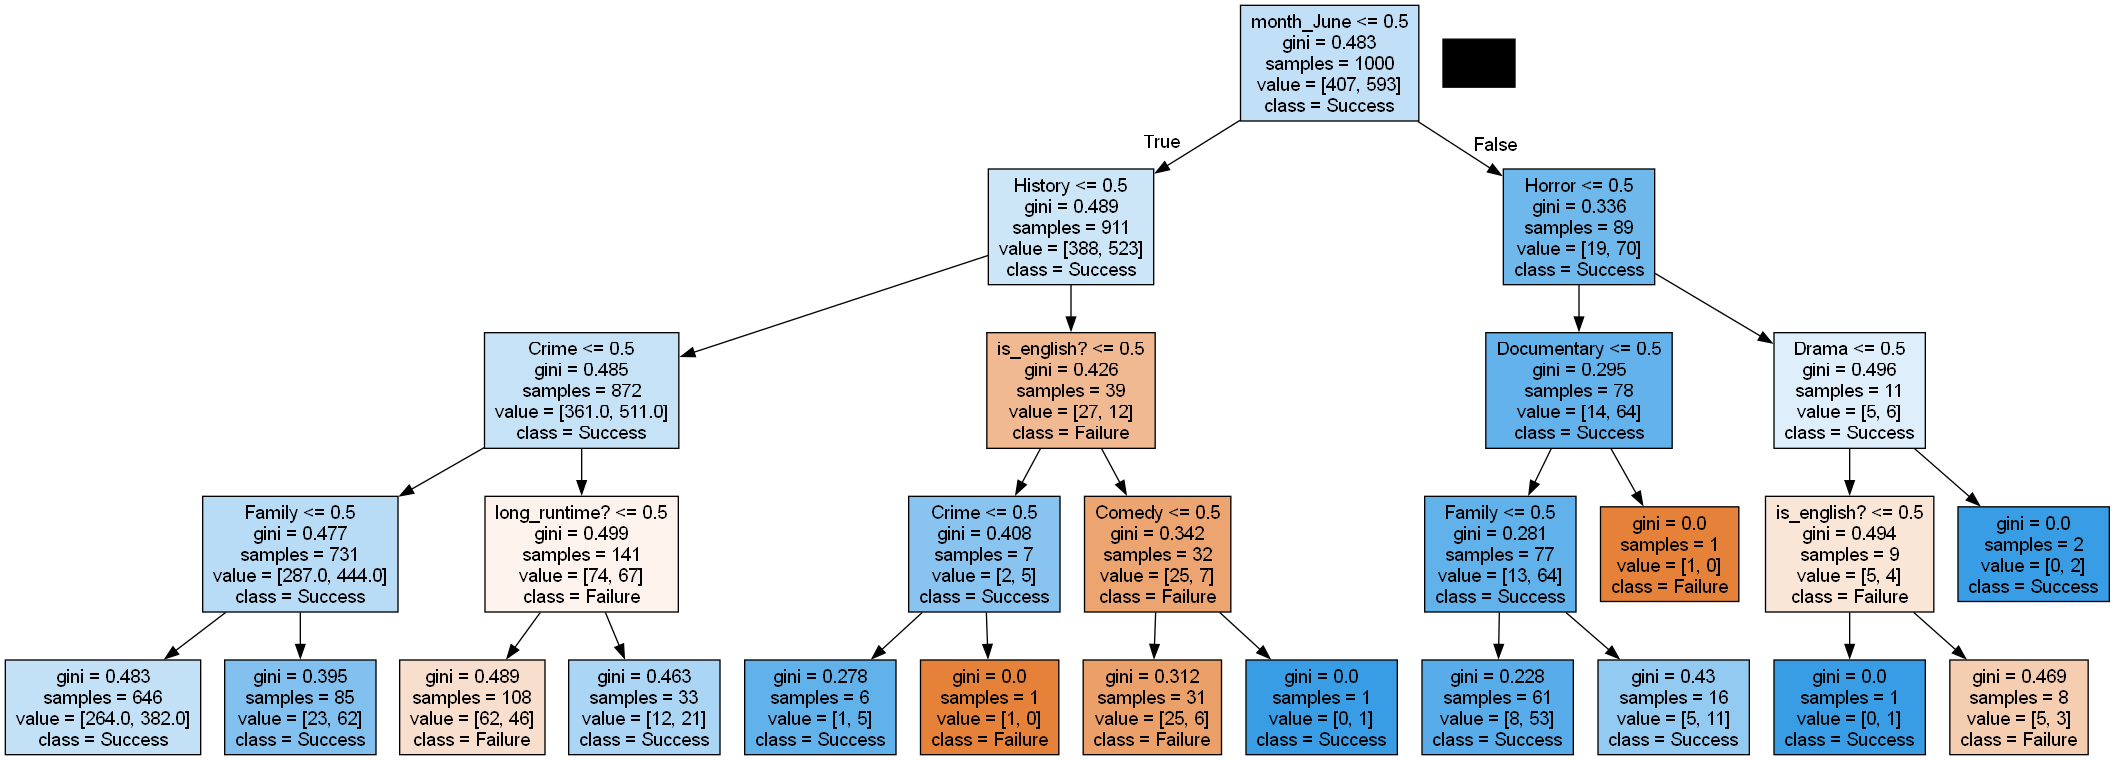

In [14]:
#Visualization of the decision tree
from sklearn.tree import export_graphviz
import pydotplus
import graphviz
from IPython.display import Image
dot_data = export_graphviz(tree, feature_names = X_predictor.columns, class_names = ['Failure','Success'], filled = True, out_file = None)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

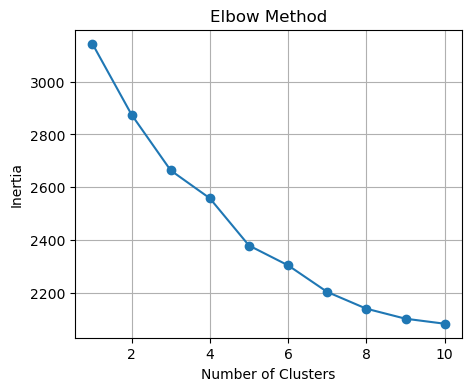

In [15]:
#3rd methodology: K-means clustering (Clustering)
#Import from libraries
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib import pyplot
import seaborn as sns

#Hide the long kmeans warning message
import warnings
warnings.filterwarnings('ignore', message='.*KMeans is known to have a memory leak.*')

#'Elbow method' calculates the optimal number of clustered needed for analysis and visualization
X = movies_df.select_dtypes(include=np.number).drop(columns=['is_success'], errors='ignore')
X.dropna(inplace=True)
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(5, 4))
plt.plot(range(1, 11), inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

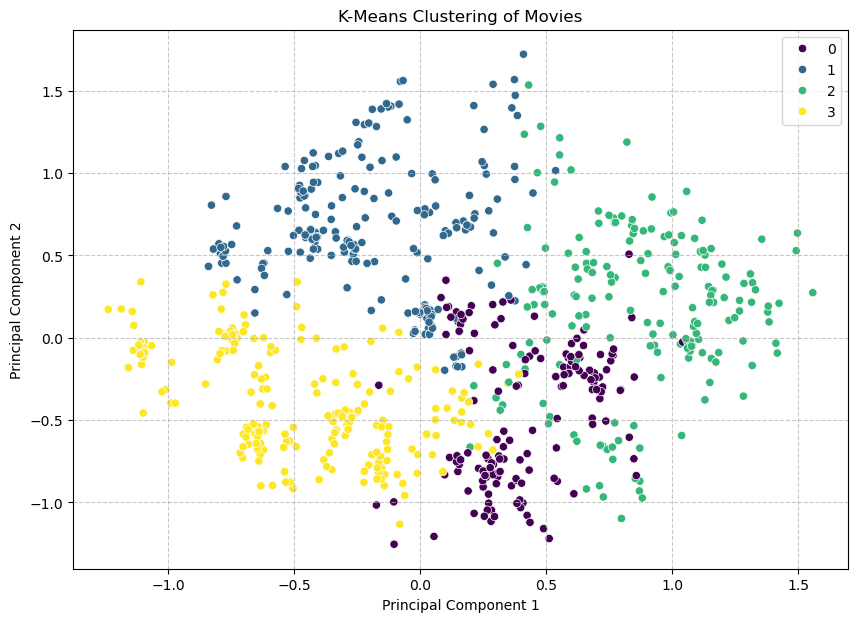

Cluster labels assigned to each movie:
[3 1 0 3 1 3 1 1 3 3 3 3 0 2 1 3 2 3 0 1 3 0 2 2 2 1 3 1 0 3 0 2 3 0 1 3 1
 0 2 1 3 1 2 3 1 3 3 1 1 1 1 1 3 0 1 2 0 2 3 2 1 3 0 0 2 2 1 1 3 0 3 3 3 2
 3 3 2 2 0 1 1 3 1 3 2 3 1 1 1 3 1 0 2 2 3 0 1 3 0 3 3 1 0 1 3 0 2 2 0 3 3
 1 3 3 1 1 1 1 2 3 1 1 3 2 0 3 2 0 1 2 3 2 3 1 0 2 1 2 2 3 3 1 0 3 1 3 0 1
 2 2 1 1 2 0 0 1 2 0 1 2 1 1 3 2 3 0 2 1 3 3 3 1 3 1 2 2 0 3 3 3 1 0 1 0 2
 1 3 1 0 3 3 1 0 3 3 0 1 3 3 2 3 0 1 3 2 3 3 2 0 1 1 3 0 3 1 0 1 0 2 3 0 2
 1 3 2 1 3 1 1 2 1 0 1 3 3 1 2 3 2 2 0 0 3 0 3 1 2 3 1 1 3 3 2 1 0 3 0 1 3
 3 3 0 2 2 2 1 3 1 3 2 3 3 1 1 1 2 2 2 1 0 0 1 2 2 1 1 3 0 0 0 1 3 3 1 2 3
 3 3 2 3 2 0 0 2 3 1 3 3 2 3 1 3 3 1 3 0 3 1 3 3 2 1 1 0 1 1 0 3 3 3 2 1 3
 0 0 3 3 2 0 1 3 2 0 3 2 3 3 2 2 1 3 1 3 1 2 2 2 1 1 0 3 3 1 1 3 3 3 3 1 2
 1 2 2 2 1 0 1 0 1 2 3 3 1 0 2 2 1 2 1 2 3 1 0 1 0 1 2 2 1 3 1 2 3 0 3 2 3
 1 3 0 2 3 2 2 2 3 1 3 1 1 2 0 2 2 3 3 1 2 1 1 1 3 1 0 3 2 0 3 0 1 2 3 2 0
 3 3 1 1 0 1 3 2 1 3 1 2 1 3 3 3 3 1 3 3 0 1 1 1 1 1 1 3 1 0 

In [16]:
#Visualization of K-means clustering

#Hide the long kmeans warning message
import warnings
warnings.filterwarnings('ignore', message='.*KMeans is known to have a memory leak.*')

#Assigning data, drop column 'is_success' since it's the target of our analysis. Only use numerical data columns like revenue and budget, drop everything else
X_cluster = movies_df.select_dtypes(include=np.number).drop(columns=['is_success'], errors='ignore')
X_cluster.dropna(inplace=True)

#K-Means clustering, use 4 clusters since the elbow method says it's the optimal amount
kmeans = KMeans(n_clusters=4, random_state=0, n_init='auto')
cluster_labels = kmeans.fit_predict(X_cluster)

#PCA 2 Dimensional plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis', legend='full')
plt.title('K-Means Clustering of Movies')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print("Cluster labels assigned to each movie:")
print(cluster_labels)

movies_df_clustered = movies_df.copy()
movies_df_clustered = movies_df_clustered.loc[X_cluster.index]
movies_df_clustered['Cluster'] = cluster_labels

for i in range(4):
    print(f"\n=== CLUSTER {i} ===")
    cluster_data = movies_df_clustered[movies_df_clustered['Cluster'] == i]
    print(f"Number of movies: {len(cluster_data)}")
    print(f"Success rate: {cluster_data['is_success'].mean():.2%}")

    numeric_cols = X_cluster.columns
    print("\nAverage characteristics:")
    print(cluster_data[numeric_cols].mean())